Adapted from a [blog post](http://www.mblondel.org/journal/2010/10/31/kernel-perceptron-in-python/) by Mathieu Blondel:

In [82]:
import numpy as np
import matplotlib.pyplot as plt

The Perceptron (Rosenblatt, 1957) is one of the oldest and simplest Machine Learning algorithms. It’s also trivial to kernelize, which makes it an ideal candidate to gain insights on *kernel methods*.

## Perceptron

The Perceptron predicts the class of an input $\mathbf{x}$ \in $\mathcal{X}$ with the function

$$f(\mathbf{x}) = \text{sign}(\mathbf{w}^T\phi(\mathbf{x}))$$

where $\text{sign}(y) = +1$ if $y > 0$ and $-1$ if $y < 0$, $\phi$ is a feature-space transformation and $\mathbf{w}$ is a feature weight vector. If  $\mathbf{x}$ is already a feature vector and a projection to another space is not needed, then $\phi(\mathbf{x})=\mathbf{x}$ (this is what is shown in the Coursera video and in the code example below).

Given a data set comprising n training examples $\mathbf{x}_1,\dots,\mathbf{x}_n$ and their corresponding labels $y_1,\dots,y_n$, where $y_n \in \{-1,+1\}$, the Perceptron makes a prediction for each $\{\mathbf{x}_i, y_i\}$ using the current estimate of $\mathbf{w}$. When the prediction is correct (equal to the label $y_i$), the algorithm jumps to the next example. When the prediction is incorrect, in order to correct for the mistake, if $y_i = +1$ then $\mathbf{w}$ is incremented by $\phi(\mathbf{x}_i)$, otherwise it is decremented by $\phi(\mathbf{x}_i)$. Since $y_i \in \{-1,+1\}$, the update rule is thus:

$$\mathbf{w} = \mathbf{w} + y_i \phi(\mathbf{x}_i)$$

Let's write a simple class to represent a Perceptron:

In [83]:
class Perceptron(object):
 
    def __init__(self, T=1):
        self.T = T
 
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # initialize parameters
        self.w = np.zeros(n_features, dtype=np.float64)
        self.b = 0.0
 
        # make T passes through the data
        for t in xrange(self.T):
            for i in xrange(n_samples):
                if self.predict(X[i])[0] != y[i]:
                    # incorrect prediction, update parameters
                    self.w += y[i] * X[i]
                    self.b += y[i]
 
    def project(self, X):
        return np.dot(X, self.w) + self.b
 
    def predict(self, X):
        X = np.atleast_2d(X)
        return np.sign(self.project(X))

Let's create some linearly separable data:

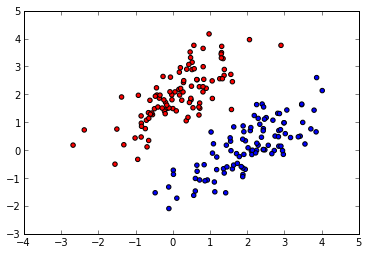

In [84]:
def gen_lin_separable_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[0.8, 0.6], [0.6, 0.8]])  # same for both classes
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

X1, y1, X2, y2 = gen_lin_separable_data()
plt.scatter(X1[:, 0], X1[:, 1], c='r', marker='o')
plt.scatter(X2[:, 0], X2[:, 1], c='b', marker='o')

In [85]:
def split_train(X1, y1, X2, y2):
        X1_train = X1[:90]
        y1_train = y1[:90]
        X2_train = X2[:90]
        y2_train = y2[:90]
        X_train = np.vstack((X1_train, X2_train))
        y_train = np.hstack((y1_train, y2_train))
        return X_train, y_train
    
def split_test(X1, y1, X2, y2):
        X1_test = X1[90:]
        y1_test = y1[90:]
        X2_test = X2[90:]
        y2_test = y2[90:]
        X_test = np.vstack((X1_test, X2_test))
        y_test = np.hstack((y1_test, y2_test))
        return X_test, y_test
    
X_train, y_train = split_train(X1, y1, X2, y2)
X_test, y_test = split_test(X1, y1, X2, y2)

print X_train.shape  # 90 examples per class
print y_train.shape
print X_test.shape  # 10 examples per class
print y_test.shape

(180, 2)
(180,)
(20, 2)
(20,)


Let's write a function to visualize the boundary defined by the model:

In [86]:
def plot_margin(X1_train, X2_train, clf):
        def f(x, w, b, c=0):
            # given x, return y such that [x,y] in on the line
            # w.x + b = c
            return (-w[0] * x - b + c) / w[1]
 
        plt.plot(X1_train[:,0], X1_train[:,1], "ro")
        plt.plot(X2_train[:,0], X2_train[:,1], "bo")
 
        # w.x + b = 0
        a0 = -4; a1 = f(a0, clf.w, clf.b)
        b0 = 4; b1 = f(b0, clf.w, clf.b)
        plt.plot([a0,b0], [a1,b1], "k")
 
        plt.axis("tight")
        plt.show()

Now, fit the model to the linearly separable data (note: three passes through the data):

In [87]:
clf = Perceptron(T=3)
clf.fit(X_train, y_train)
print "w_0 = %6.4f, w_1 = %6.4f, b = %6.4f" % (clf.w[0], clf.w[1], clf.b)

w_0 = -5.1058, w_1 = 3.2153, b = 0.0000


Evaluate the model on the test data:

19 out of 20 predictions correct


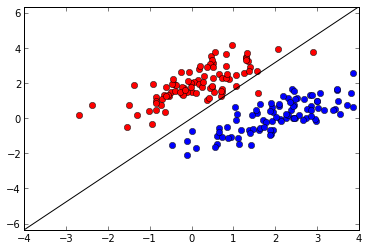

In [88]:
y_predict = clf.predict(X_test)
correct = np.sum(y_predict == y_test)
print "%d out of %d predictions correct" % (correct, len(y_predict))
 
plot_margin(X_train[y_train==1], X_train[y_train==-1], clf)

Now, let's generate non-linearly separable data:

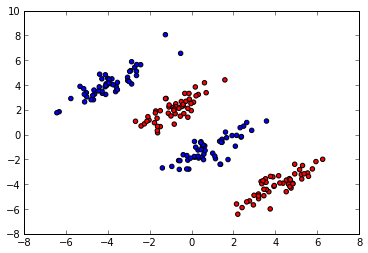

In [89]:
def gen_non_lin_separable_data():
        mean1 = [-1, 2]
        mean2 = [1, -1]
        mean3 = [4, -4]
        mean4 = [-4, 4]
        cov = [[1.0,0.8], [0.8, 1.0]]  # shared
        X1 = np.random.multivariate_normal(mean1, cov, 50)
        X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 50)
        X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

X1, y1, X2, y2 = gen_non_lin_separable_data()
plt.scatter(X1[:, 0], X1[:, 1], c='r', marker='o')
plt.scatter(X2[:, 0], X2[:, 1], c='b', marker='o')

Split the data (note the shuffling, this is very common practice!):

In [90]:
# shuffle data before splitting (otherwise all test data would come
# from the same cluster)
rp = np.random.permutation(X1.shape[0])
X1 = X1[rp]
y1 = y1[rp]

rp = np.random.permutation(X2.shape[0])
X2 = X2[rp]
y2 = y2[rp]

X_train, y_train = split_train(X1, y1, X2, y2)
X_test, y_test = split_test(X1, y1, X2, y2)

print X_train.shape  # 90 examples per class
print y_train.shape
print X_test.shape  # 10 examples per class
print y_test.shape

(180, 2)
(180,)
(20, 2)
(20,)


Fit the model to the non-linearly separable data

In [91]:
clf = Perceptron(T=3)
clf.fit(X_train, y_train)

Evaluate the model on the test data

10 out of 20 predictions correct


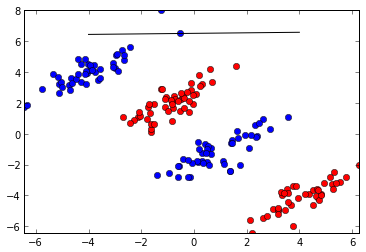

In [92]:
y_predict = clf.predict(X_test)
correct = np.sum(y_predict == y_test)
print "%d out of %d predictions correct" % (correct, len(y_predict))
 
plot_margin(X_train[y_train==1], X_train[y_train==-1], clf)

### Exercise:

Take the current model and classify a few examples by hand (using some data points in the data set).

### Exercise:

Modify the plots so that they show the test data as well as the train data (e.g. using a different marker shape).

### Exercise:

Modify the code so that the bias is simply an extra dimension on the weight vector.

## Kernel Perceptron (optional)

From the update rule above, we clearly see that, if $\mathbf{w}$ is initialized to the zero vector, it is a linear combination of the training examples.

$$\mathbf{w} = \sum_i \alpha_i y_i \phi(\mathbf{x}_i)$$

Injecting $\mathbf{w}$ into the prediction function $f(\mathbf{x})$, we get:

$$f(\mathbf{x}) = \text{sign}(\sum_i \alpha_i y_i \phi(\mathbf{x}_i)^T\phi(\mathbf{x})) = \text{sign}(\sum_i \alpha_i y_i K(\mathbf{x}_i,\mathbf{x}))$$

where $K(\mathbf{x}_i,\mathbf{x}) = \phi(\mathbf{x}_i)^T\phi(\mathbf{x})$ is a [Mercer kernel](http://en.wikipedia.org/wiki/Kernel_trick).

The update rule for when a mistake is made predicting \mathbf{x}_i now simply becomes

$$\alpha_i = \alpha_i + 1$$

i.e., $\alpha_i$ is the number of times a mistake has been made with respect to $\mathbf{x}_i$.

A few remarks:

* Instead of learning a weight vector $\mathbf{w}$ with respect to features, we’re now learning a weight vector $\boldsymbol{\alpha}$ with respect to examples.
* To predict the class of an input $\mathbf{x}$, we need to store the training examples $\mathbf{x}_i$. Kernel methods are memory-based methods, like $k$-NN. However, we only need to store examples for which a mistake has been made, i.e. ${\alpha}_i \neq 0$. In the context of Support Vector Machines (SVMs), these are called support vectors. SVMs, however, not only store examples for which a mistake has been made, they also store examples that lie inside the margin, i.e. $y_i (\mathbf{w}^T \phi(\mathbf{x}_i)) \le 1$. 
* In the online learning setting, the number of support vectors can grow and grow as more mistakes are made. The [Forgetron](http://books.nips.cc/papers/files/nips18/NIPS2005_0192.pdf) is an extension of the Kernel Perceptron which can learn with a “memory budget”. When the budget is exceeded, some support vectors are “forgotten”.
* For some kinds of objects like sequences, trees and graphs, it might be difficult to map objects to feature vectors while it is easy to come up with a similarity measure $K(\mathbf{x}_i,\mathbf{x}_j)$ between any two objects $\mathbf{x}_i$ and $\mathbf{x}_j$. In this case, kernel methods are very useful, since they can be used “as is”.

Let's define some different types of kernels (note: the linear kernel gives us back the original Perceptron):

In [93]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)
 
def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p
 
def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

Now define a Kernel Perceptron class:

In [94]:
class KernelPerceptron(object):
 
    def __init__(self, kernel=linear_kernel, T=1):
        self.kernel = kernel
        self.T = T
 
    def fit(self, X, y):
        n_samples, n_features = X.shape
        #np.hstack((X, np.ones((n_samples, 1))))
        self.alpha = np.zeros(n_samples, dtype=np.float64)
 
        # K is called the Gram matrix
        # Note that for this simple example we can compute the
        # Gram matrix, but often this is wasteful
        # Also, what about the case of online learning?
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])
 
        for t in range(self.T):
            for i in range(n_samples):
                if np.sign(np.sum(K[:,i] * self.alpha * y)) != y[i]:
                    self.alpha[i] += 1.0
 
        # Support vectors
        sv = self.alpha > 1e-5
        ind = np.arange(len(self.alpha))[sv]
        self.alpha = self.alpha[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print "%d support vectors out of %d points" % (len(self.alpha),
                                                       n_samples)
 
    def project(self, X):
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for a, sv_y, sv in zip(self.alpha, self.sv_y, self.sv):
                s += a * sv_y * self.kernel(X[i], sv)
            y_predict[i] = s
        return y_predict
 
    def predict(self, X):
        X = np.atleast_2d(X)
        n_samples, n_features = X.shape
        #np.hstack((X, np.ones((n_samples, 1))))
        return np.sign(self.project(X))

Let's train the Kernel Perceptron on the non-linearly separable data:

In [95]:
clf = KernelPerceptron(gaussian_kernel, T=20)
clf.fit(X_train, y_train)
 

17 support vectors out of 180 points


Let's test it on the test set:

In [96]:
y_predict = clf.predict(X_test)
correct = np.sum(y_predict == y_test)
print "%d out of %d predictions correct" % (correct, len(y_predict))

20 out of 20 predictions correct


Define a fancier plotting function to show the separation boundary learned by the nonlinear model as well as the support vectors (green circles):

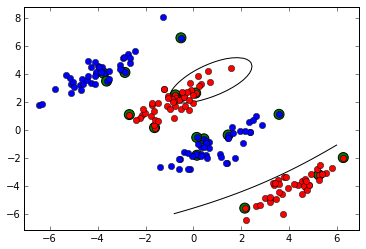

In [97]:
def plot_contour(X1_train, X2_train, clf):
        plt.plot(X1_train[:,0], X1_train[:,1], "ro")
        plt.plot(X2_train[:,0], X2_train[:,1], "bo")
        plt.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")
 
        X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = clf.project(X).reshape(X1.shape)
        plt.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
 
        plt.axis("tight")
        plt.show()

plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

### Exercise

Try out the polynomial kernel of different orders.

### Exercise

Read about other kernels and try to implement one or more of them.